## Instruction
In this notebook, we load data from privious step in `Factor_Process_and_Evaluate.ipynb` and we combine all factors by RandomForest method. Then we can evaluate all factors.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import helper.project_helper as ph

%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (8, 4)

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [3]:
## load universe_factors
universe = pd.read_csv('factor_data/all_108_zscore.csv')
universe['date'] = pd.to_datetime(universe['trade_date'],format='%Y%m%d')
universe.set_index(['date'],inplace=True)
universe = universe.loc[universe['trade_date']>20200401]
universe.head()

,ts_code,trade_date,name,industry,close,issue_price,log-ret,alpha_atr,alpha_pb,alpha_ppo,alpha_kama,alpha_010,alpha_040,alpha_069,alpha_075,alpha_122,alpha_030,alpha_149,alpha_016,alpha_032
date,,,,,,,,,,,,,,,,,,,,
2020-04-02,300531.SZ,20200402,优博讯,软件服务,15.19413,13.36,0.016475,0.780801,0.191493,0.021445,0.293776,0.574557,0.186771,-0.147645,0.006702,0.232615,0.391708,0.526886,0.177972,0.079775
2020-04-02,002380.SZ,20200402,科远智慧,软件服务,15.19603,39.00,0.051960,-0.061742,0.946338,-1.000000,0.726403,0.574415,-0.384144,-0.623321,-0.887240,-1.000000,0.554675,0.571631,-1.000000,0.079775
2020-04-02,300789.SZ,20200402,唐源电气,软件服务,34.24234,35.58,0.013710,-0.344304,-0.049995,0.214903,-0.182065,-0.702106,-0.518187,1.000000,1.000000,-0.019986,-0.027953,0.208973,0.369141,0.079775
2020-04-02,300639.SZ,20200402,凯普生物,医疗保健,14.96750,18.39,-0.013539,1.000000,-0.868947,-0.027709,1.000000,1.000000,0.155126,-1.000000,0.740741,0.485396,0.999159,-0.341177,-0.639489,0.079775
2020-04-02,600587.SH,20200402,新华医疗,医疗保健,16.71117,29.70,0.002938,0.913195,1.000000,-0.075221,0.905697,0.894646,-0.876309,-0.211829,0.481481,0.173895,0.797879,-1.000000,-0.593709,0.079775


### One Hot Encode Sectors
For the model to better understand the sector data, we'll one hot encode this data.

In [4]:
universe.industry.unique()

array(['软件服务', '医疗保健', '化学制药', '中成药', 'IT设备', '互联网', '生物制药', '化工原料',
       '医药商业', '元器件', '半导体'], dtype=object)

In [5]:
sector_dict = {'软件服务':1, '医疗保健':2, '化学制药':3, '中成药':4, 'IT设备':5, '互联网':6, '生物制药':7, '化工原料':8,
       '医药商业':9, '元器件':10, '半导体':11}
all_factors = universe.copy(deep=True)
sector_columns = []
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = False
    sector_columns.append('sector_{}'.format(sector_i))
    
for sector_name, sector_i in sector_dict.items():
    all_factors['sector_{}'.format(sector_i)] = np.where(all_factors['industry']==sector_name, True, False)

all_factors.head()

,ts_code,trade_date,name,industry,close,issue_price,log-ret,alpha_atr,alpha_pb,alpha_ppo,...,sector_2,sector_3,sector_4,sector_5,sector_6,sector_7,sector_8,sector_9,sector_10,sector_11
date,,,,,,,,,,,,,,,,,,,,,
2020-04-02,300531.SZ,20200402,优博讯,软件服务,15.19413,13.36,0.016475,0.780801,0.191493,0.021445,...,False,False,False,False,False,False,False,False,False,False
2020-04-02,002380.SZ,20200402,科远智慧,软件服务,15.19603,39.00,0.051960,-0.061742,0.946338,-1.000000,...,False,False,False,False,False,False,False,False,False,False
2020-04-02,300789.SZ,20200402,唐源电气,软件服务,34.24234,35.58,0.013710,-0.344304,-0.049995,0.214903,...,False,False,False,False,False,False,False,False,False,False
2020-04-02,300639.SZ,20200402,凯普生物,医疗保健,14.96750,18.39,-0.013539,1.000000,-0.868947,-0.027709,...,True,False,False,False,False,False,False,False,False,False
2020-04-02,600587.SH,20200402,新华医疗,医疗保健,16.71117,29.70,0.002938,0.913195,1.000000,-0.075221,...,True,False,False,False,False,False,False,False,False,False


### Target
Let's try to predict the go forward 1-week return. When doing this, it's important to quantize the target. The factor we create is the trailing 5-day return.

In [6]:
quantile_jud = all_factors['log-ret'].quantile([0.33,0.66,1.])
quantile_jud

0.33   -0.010576
0.66    0.008572
1.00    0.258654
Name: log-ret, dtype: float64

In [7]:
def get_return_quantiles(all_factors):
    all_factors['return_2q'] = 0
    all_factors['return_2q'] = np.where(all_factors['log-ret']<=-0.01, -1, all_factors['return_2q'])
    all_factors['return_2q'] = np.where(all_factors['log-ret']>=0.01, 1 , all_factors['return_2q'])
        
    return all_factors

all_factors = get_return_quantiles(all_factors)

### Shift Target
We'll use shifted 5 day returns for training the model.

As some alpha factors measure time is not same, we can also shift.

In [9]:
# save all_factors which is no need to train
universe = all_factors.copy(deep=True)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors['target'] = all_factors.groupby('ts_code')['return_2q'].shift(-2).fillna(0).astype(np.int16)

In [10]:
all_factors['target'].unique()

array([ 1,  0, -1], dtype=int16)

### IID Check of Target
Let's see if the returns are independent and identically distributed.

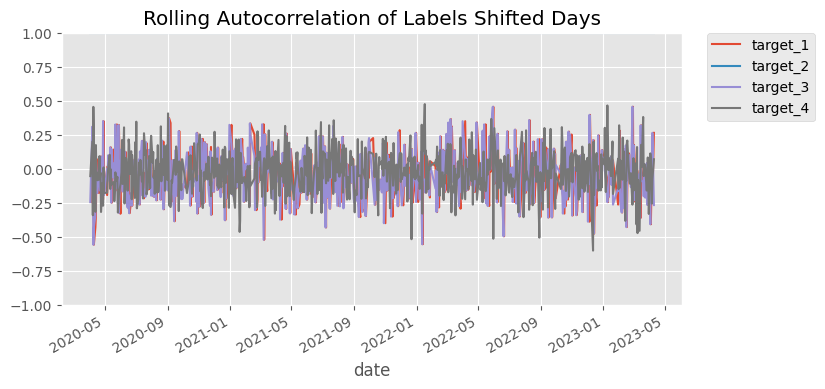

In [11]:
all_factors.reset_index(inplace=True)
all_factors.set_index(['date','ts_code'],inplace=True)
tmp = all_factors.loc[all_factors['trade_date']>20220501]
ph.IID_check(all_factors)

### Train/Valid/Test Splits
Split the data into a train, validation, and test set. For this, we'll use some of the features and the 5 day returns for our target.

In [12]:
features = [
            'alpha_atr', 'alpha_pb', 'alpha_ppo', 'alpha_kama', 
            'alpha_010', 'alpha_040', 'alpha_069', 'alpha_075', 'alpha_122',
            'alpha_030', 'alpha_149', 'alpha_016', 'alpha_032'
            ] + sector_columns

target_label = 'target'
print(all_factors.shape)

(69262, 36)


In [13]:
all_factors = all_factors.replace([np.inf, -np.inf], np.nan)
all_factors = all_factors[~all_factors.isin([np.nan, np.inf, -np.inf]).any(1)]
all_factors.reset_index(inplace=True)
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date','ts_code']).sort_values(by=['date'])
print(all_factors.shape)
all_factors.head()

(68834, 36)


trade_date  name industry     close  issue_price  \
date       ts_code                                                       
2020-04-02 300531.SZ    20200402   优博讯     软件服务  15.19413        13.36   
           300583.SZ    20200402  赛托生物     化学制药  27.55446        40.29   
           300109.SZ    20200402   新开源     化工原料  14.54522        30.00   
           603590.SH    20200402  康辰药业     生物制药  36.42779        24.34   
           300294.SZ    20200402  博雅生物     生物制药  31.56177        25.00   

                       log-ret  alpha_atr  alpha_pb  alpha_ppo  alpha_kama  \
date       ts_code                                                           
2020-04-02 300531.SZ  0.016475   0.780801  0.191493   0.021445    0.293776   
           300583.SZ  0.017531   0.267434  1.000000   0.545559   -0.503834   
           300109.SZ  0.023452   0.000000  0.000000   0.000000    0.000000   
           603590.SH  0.007189   0.402171  0.744568   0.110500    1.000000   
           300294.SZ  0.019308  -1.000000 -1.000000   1.000000   -1.000000   

                      ...  sector_8  sector_9  sector_10  sector_11  \
date       ts_code    ...                                             
2020-04-02 300531.SZ  ...     False     False      False      False   
           300583.SZ  ...     False     False      False      False   
           300109.SZ  ...      True     False      False      False   
           603590.SH  ...     False     False      False      False   
           300294.SZ  ...     False     False      False      False   

                      return_2q  target  target_1  target_2  target_3  \
date       ts_code                                                      
2020-04-02 300531.SZ          1       1      -1.0       1.0       0.0   
           300583.SZ          1       1       0.0       1.0       0.0   
           300109.SZ          1       1       0.0       1.0      -1.0   
           603590.SH          0       1       1.0       1.0       0.0   
           300294.SZ          1       1       0.0       1.0      -1.0   

                      target_4  
date       ts_code              
2020-04-02 300531.SZ       1.0  
           300583.SZ       1.0  
           300109.SZ       0.0  
           603590.SH       0.0  
           300294.SZ       0.0  

[5 rows x 36 columns]

In [14]:
tmp = all_factors.dropna().copy()
X = tmp[features]
y = tmp[target_label].astype(np.int16)

X_train, X_valid, X_test, y_train, y_valid, y_test = ph.train_valid_test_split(X, y, 0.7, 0.15, 0.15)

X_valid.tail()

alpha_atr  alpha_pb  alpha_ppo  alpha_kama  alpha_010  \
date       ts_code                                                            
2022-10-26 301130.SZ  -0.088191  0.252995   0.592724    0.418814  -0.127888   
           003020.SZ  -0.624163 -0.063916  -1.000000   -0.735803  -0.450903   
           002940.SZ  -0.310994  0.152159  -0.927219   -0.774042  -0.160406   
           002923.SZ   0.641739 -0.102826   0.138739    0.717673   0.709658   
           300677.SZ   0.672171  1.000000   0.506478    0.861054   0.916982   

                      alpha_040  alpha_069  alpha_075  alpha_122  alpha_030  \
date       ts_code                                                            
2022-10-26 301130.SZ   0.556579   0.569472   0.938972   0.798936   0.215337   
           003020.SZ  -1.000000  -0.313613  -1.000000  -0.767953  -0.053880   
           002940.SZ  -0.658422  -0.547834  -0.083812  -0.945383   0.931335   
           002923.SZ   0.497170  -0.250716  -0.083812   0.213599   0.881777   
           300677.SZ   0.424153   0.047189  -0.913043   0.497574   0.965612   

                      ...  sector_2  sector_3  sector_4  sector_5  sector_6  \
date       ts_code    ...                                                     
2022-10-26 301130.SZ  ...     False      True     False     False     False   
           003020.SZ  ...     False      True     False     False     False   
           002940.SZ  ...     False      True     False     False     False   
           002923.SZ  ...     False      True     False     False     False   
           300677.SZ  ...      True     False     False     False     False   

                      sector_7  sector_8  sector_9  sector_10  sector_11  
date       ts_code                                                        
2022-10-26 301130.SZ     False     False     False      False      False  
           003020.SZ     False     False     False      False      False  
           002940.SZ     False     False     False      False      False  
           002923.SZ     False     False     False      False      False  
           300677.SZ     False     False     False      False      False  

[5 rows x 24 columns]

### Train Random Forests with Different Tree Sizes
Let's build models using different tree sizes to find the model that best generalizes.
#### Parameters
When building the models, we'll use the following parameters.

In [18]:
n_days = 50
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 2000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}
n_trees_l = [20,50,70]

### Pick Important Features by Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier


train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    clf.fit(X_train, y_train)
    
    train_score.append(clf.score(X_train, y_train.values))
    valid_score.append(clf.score(X_valid, y_valid.values))
    oob_score.append(clf.oob_score_)
    feature_importances.append(clf.feature_importances_)

Training Models: 100%|█████████████████████████| 3/3 [00:03<00:00,  1.28s/Model]


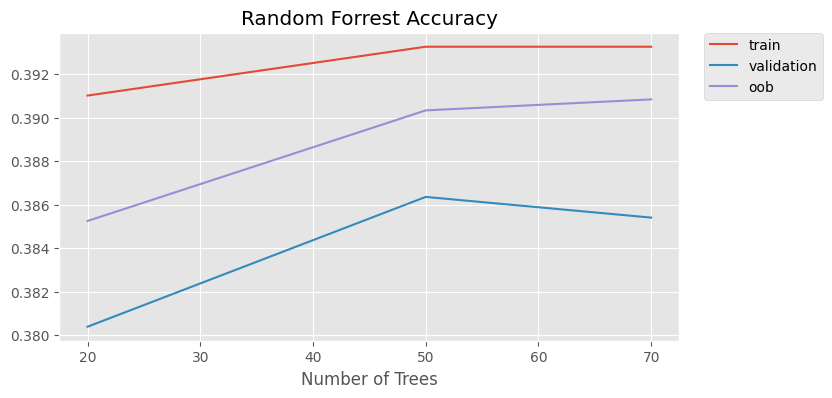

Features Ranked by Average Importance:

      Feature        Importance
 1. alpha_075  (0.28568866937335885)
 2. alpha_pb   (0.16281564908040833)
 3. alpha_030  (0.14219558577636895)
 4. alpha_149  (0.10794989580537011)
 5. alpha_atr  (0.09165203987914146)
 6. alpha_ppo  (0.04833870649067645)
 7. alpha_122  (0.03841122173777978)
 8. alpha_032  (0.03515402639421413)
 9. alpha_kama (0.03176109327164686)
10. alpha_069  (0.021301549764879867)
11. alpha_040  (0.017053473517492573)
12. alpha_016  (0.012867069891218505)
13. alpha_010  (0.004373945337213779)
14. sector_3   (0.000437073680230351)
15. sector_10  (0.0)
16. sector_1   (0.0)
17. sector_2   (0.0)
18. sector_4   (0.0)
19. sector_5   (0.0)
20. sector_6   (0.0)
21. sector_7   (0.0)
22. sector_8   (0.0)
23. sector_9   (0.0)
24. sector_11  (0.0)


In [20]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')
print('Features Ranked by Average Importance:\n')
ph.rank_features_by_importance(np.average(feature_importances, axis=0), features)

### Build an ensemble of non-overlapping trees
The last method is to create ensemble of non-overlapping trees. Here we are going to write a custom `scikit-learn` estimator. We inherit from `VotingClassifier` and we override the `fit` method so we fit on non-overlapping periods.

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import Bunch

class NoOverlapVoter(VotingClassifier):
    
    def _calculate_oob_score(self, classifiers):
        oob = 0
        for clf in classifiers:
            oob = oob + clf.oob_score_
        return oob / len(classifiers)
        
    def _non_overlapping_estimators(self, x, y, classifiers, n_skip_samples):
        estimators_ = []
        for i in range(n_skip_samples):
            estimators_.append(
                classifiers[i].fit(x[i::n_skip_samples], y[i::n_skip_samples])
            )
        return estimators_
    
    def __init__(self, estimator, voting='soft', n_skip_samples=5):
        # List of estimators for all the subsets of data
        estimators = [('clf'+str(i), estimator) for i in range(n_skip_samples + 1)]
        
        self.n_skip_samples = n_skip_samples
        super().__init__(estimators, voting=voting)
    
    def fit(self, X, y, sample_weight=None):
        estimator_names, clfs = zip(*self.estimators)
        self.le_ = LabelEncoder().fit(y)
        self.classes_ = self.le_.classes_
        
        clone_clfs = [clone(clf) for clf in clfs]
        self.estimators_ = self._non_overlapping_estimators(X, y, clone_clfs, self.n_skip_samples)
        self.named_estimators_ = Bunch(**dict(zip(estimator_names, self.estimators_)))
        self.oob_score_ = self._calculate_oob_score(self.estimators_)
        
        return self

### Train Model

In [24]:
n_days = 16
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 500,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [40, 80, 100, 120]

train_score = []
valid_score = []
oob_score = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    clf = RandomForestClassifier(n_trees, **clf_parameters)
    
    clf_nov = NoOverlapVoter(clf)
    clf_nov.fit(X_train, y_train)
    
    train_score.append(clf_nov.score(X_train, y_train.values))
    valid_score.append(clf_nov.score(X_valid, y_valid.values))
    oob_score.append(clf_nov.oob_score_)

Training Models: 100%|█████████████████████████| 5/5 [00:17<00:00,  3.51s/Model]


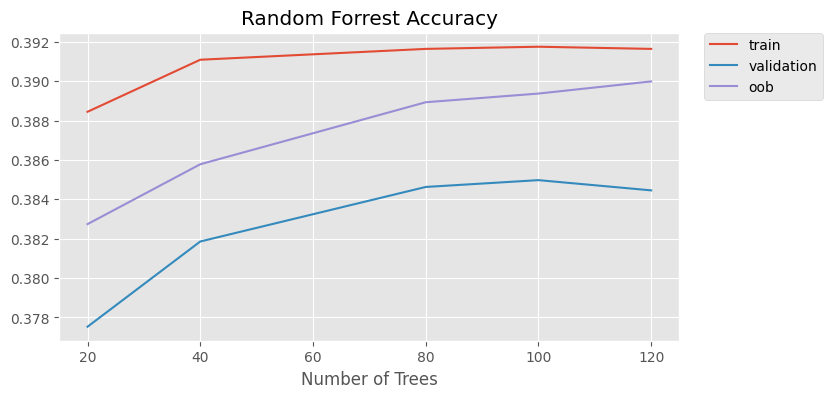

In [25]:
ph.plot(
    [n_trees_l]*4,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Predict on the test data
predictions = clf_nov.predict(X_valid)

# Score our model average='micro' if report error
print('Accuracy score: ', format(accuracy_score(y_valid.values, predictions)))
print('Precision score: ', format(precision_score(y_valid.values, predictions, average='micro')))
print('Recall score: ', format(recall_score(y_valid.values, predictions, average='micro')))
print('F1 score: ', format(f1_score(y_valid.values, predictions, average='micro')))

Accuracy score:  0.3844555997922797
Precision score:  0.3844555997922797
Recall score:  0.3844555997922797
F1 score:  0.3844555997922797


In [27]:
factor_names = [ 
            'alpha_atr', 'alpha_pb', 'alpha_ppo', 'alpha_kama', 
            'alpha_010', 'alpha_040', 'alpha_069', 'alpha_075',
            'alpha_030', 'alpha_149',
            ]

all_pricing = all_factors.reset_index().pivot(index='date', columns='ts_code', values='close')
all_pricing.head()

tmp = all_factors.copy(deep=True)
tmp['close'] = all_factors.groupby('ts_code')['close'].shift(-2)
tmp.loc[tmp.index.get_level_values(1) == '603538.SH']['close']
all_pricing = tmp.reset_index().pivot(index='date', columns='ts_code', values='close')

### Evalueate alpha factor

In [28]:
import alphalens as al
from scipy.stats import zscore

def show_sample_results(data, samples, classifier, factors, pricing=all_pricing):
    # Calculate the Alpha Score
    prob_array=[-1, 0, 1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))
    
    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
    factors_with_alpha = factors_with_alpha.reset_index()
    factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
    factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    # Setup data for AlphaLens
    print('Cleaning Data...\n')
    factor_data = ph.build_factor_data(factors_with_alpha[factors + [alpha_score_label]], pricing, holding_time=5)
    print('\n-----------------------\n')
    
    # Calculate Factor Returns and Sharpe Ratio
    factor_returns = ph.get_factor_returns(factor_data)
    sharpe_ratio = ph.sharpe_ratio(factor_returns)
    
    # Show Results
    print('             Sharpe Ratios')
    print(sharpe_ratio.round(2))
    ph.plot_factor_returns(factor_returns)
    ph.plot_factor_rank_autocorrelation(factor_data)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

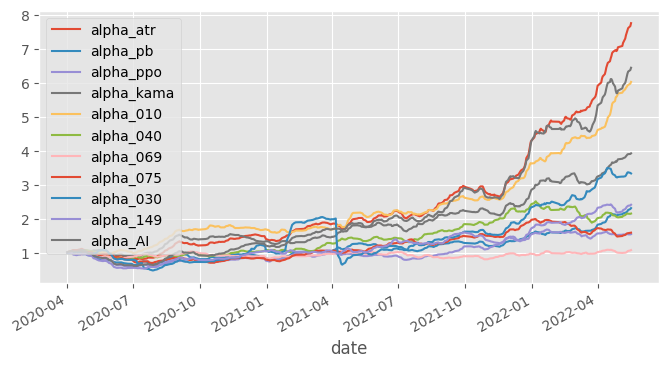

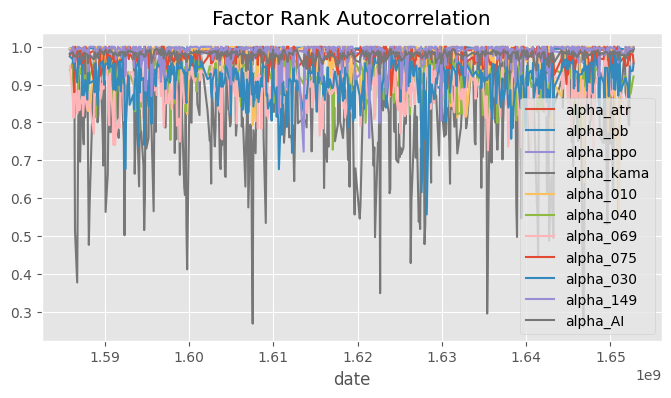

In [29]:
show_sample_results(all_factors, X_train, clf_nov, factor_names, pricing=all_pricing)

Cleaning Data...

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

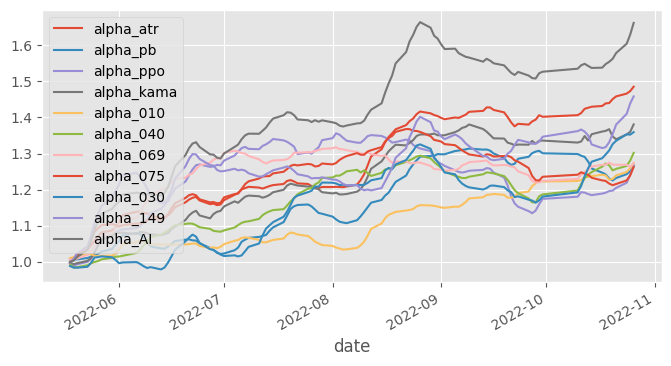

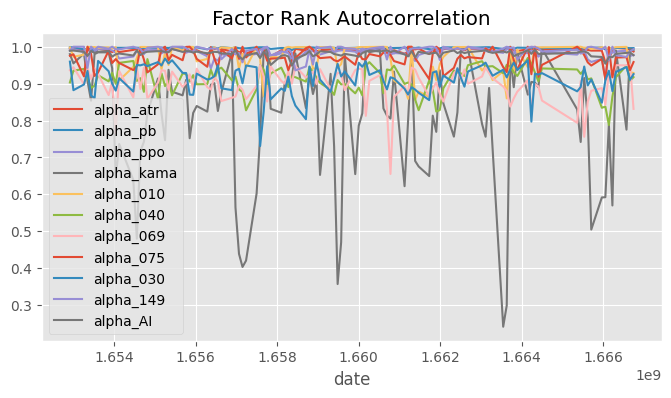

In [30]:
show_sample_results(all_factors, X_valid, clf_nov, factor_names, pricing=all_pricing)

## Final Model
### Re-Training Model
In production, we would roll forward the training. Typically you would re-train up to the "current day" and then test. Here, we will train on the train & validation dataset.

In [31]:
n_days = 16
n_stocks = len(all_factors.index.get_level_values(1).unique())

clf_parameters = {
    'max_features':'sqrt',
    'criterion': 'entropy',
    #'min_samples_split' : 1000,
    'min_samples_leaf': n_stocks*n_days,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees = 105

train_score = []
valid_score = []
oob_score = []

clf = RandomForestClassifier(n_trees, **clf_parameters)
    
clf_nov = NoOverlapVoter(clf)
clf_nov.fit(
    pd.concat([X_train, X_valid]),
    pd.concat([y_train, y_valid]))

train_score.append(clf_nov.score(X_train, y_train.values))
valid_score.append(clf_nov.score(X_valid, y_valid.values))
oob_score.append(clf_nov.oob_score_)

In [32]:
print(train_score)
print(valid_score, oob_score)

[0.39452471147916485]
[0.39025445733079456] [0.39093719668543764]


### View Train Set Results

Cleaning Data...

Dropped 2.8% entries from factor data: 2.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.8% entries from factor data: 2.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.8% entries from factor data: 2.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.8% entries from factor data: 2.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 2.8% entries from factor data: 2.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

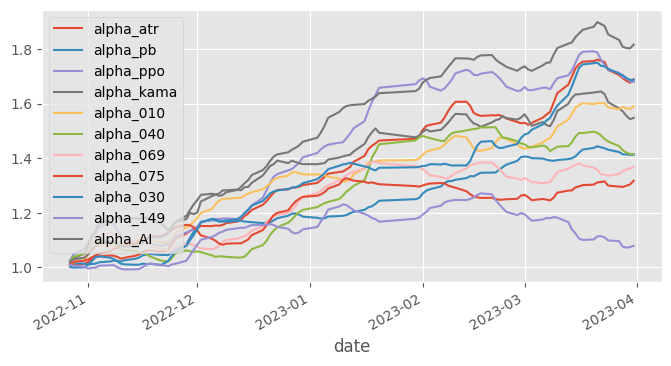

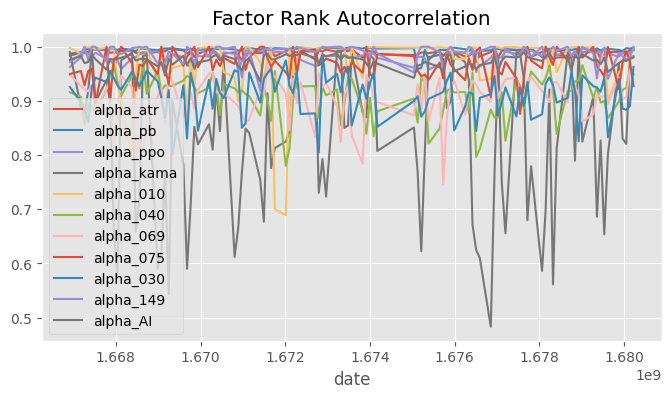

In [33]:
#show_sample_results(all_factors, pd.concat([X_train, X_valid]), clf_nov, factor_names, pricing=all_pricing)
show_sample_results(all_factors, X_test, clf_nov, factor_names, pricing=all_pricing)

### View Test Set Results

Cleaning Data...

Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.4% entries from factor data: 1.4% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceed

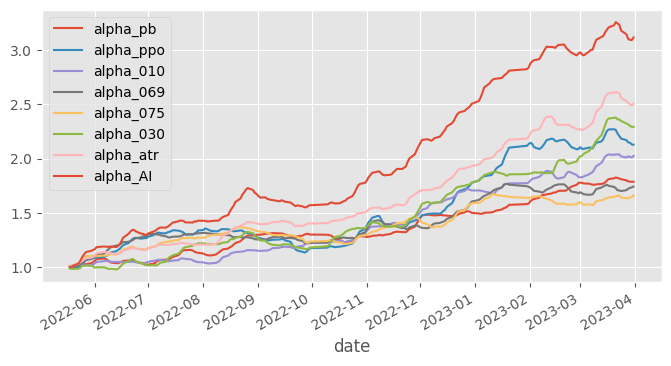

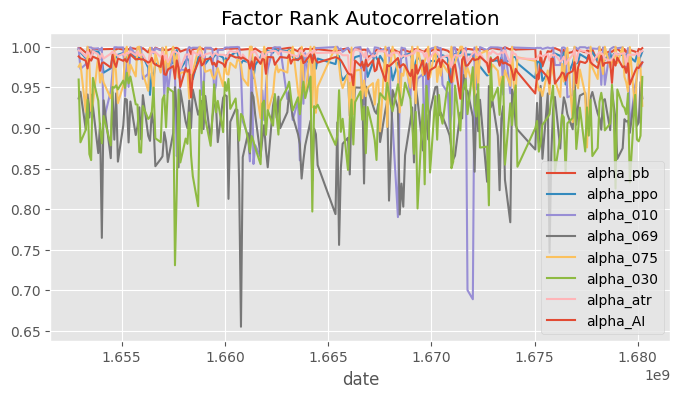

In [35]:
factor_names = [
            'alpha_pb', 'alpha_ppo',
            'alpha_010', 'alpha_069', 'alpha_075',
            'alpha_030', 'alpha_atr',
           ]
#tmp = pd.concat([X_train, X_valid])
tmp = pd.concat([X_valid, X_test])
show_sample_results(all_factors, tmp, clf_nov, factor_names, pricing=all_pricing)

### Merage AI factors

In [36]:
def save_AI_factors(data, classifier):
    # Calculate the Alpha Score
    samples = data[features]
    prob_array=[-1,0,1]
    alpha_score = classifier.predict_proba(samples).dot(np.array(prob_array))

    # Add Alpha Score to rest of the factors
    alpha_score_label = 'alpha_AI'
    print(alpha_score, len(alpha_score))
    factors_with_alpha = data.loc[samples.index].copy()
    factors_with_alpha[alpha_score_label] = alpha_score
    
#     factors_with_alpha = factors_with_alpha.reset_index()
#     factors_with_alpha[[alpha_score_label,'close']] = factors_with_alpha.groupby('date')[[alpha_score_label,'close']].apply(zscore)
#     factors_with_alpha = factors_with_alpha.set_index(['date','ts_code']).sort_values(by=['date'])
    
    return factors_with_alpha
    
save_factors = save_AI_factors(all_factors, clf_nov)
save_factors = save_factors.reset_index().set_index(['date'])
save_factors = universe.merge(save_factors[['alpha_AI','ts_code','trade_date']], on=['ts_code','trade_date'], how='left')

[-0.02160019 -0.02064563 -0.03803805 ... -0.03383584 -0.02500152
 -0.04972012] 68834


In [37]:
#save_factors['alpha_pb'] = -save_factors['pb']
field = ['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
         'alpha_atr', 'alpha_010', 'alpha_AI'
        ]
save_factors[field].to_csv('AI_data/factors_AI_108.csv')

### Save RandomForest Model

In [38]:
import joblib

joblib.dump(clf_nov, 'AI_data/clf_108.pkl')


['AI_data/clf_108.pkl']

Load model example

In [ ]:
clf_load = joblib.load('clf_20230401.pkl') 
alpha_score = clf_load.predict_proba(all_factors[features]).dot(np.array([-1, 0, 1]))
print(alpha_score, len(alpha_score))